<a href="https://colab.research.google.com/github/hijera/NN_colab_hw/blob/main/%D0%94%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D0%B5%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_%D0%BF%D0%BE_%D1%82%D0%B5%D0%BC%D0%B5_%C2%AB%D0%AD%D0%BB%D0%B5%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%80%D0%BD%D1%8B%D0%B5_%D0%BC%D0%B5%D1%82%D0%BE%D0%B4%D1%8B_%D0%B0%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7%D0%B0_%D0%B2%D1%80%D0%B5%D0%BC%D0%B5%D0%BD%D0%BD%D1%8B%D1%85_%D1%80%D1%8F%D0%B4%D0%BE%D0%B2%C2%BB_(%D0%92%D0%BB%D0%B0%D1%81%D0%BE%D0%B2_%D0%90%D0%BD%D1%82%D0%BE%D0%BD).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Задание

1. Возьмите из прошлого домашнего задания ряд — стационарный и не стационарный.
2. Приблизьте оба варианта моделями из класса MA.
3. Оцените качество и пришлите соображения, почему была выбрана та или иная модель.



In [ ]:
#Возьмем 2 ряда - Monthly sales of company X (нестационарный) и Mean monthly air temperature (Deg. F) Nottingham Castle (стационарный)
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
#Скачиваем поочередно ряды
sales_of_company_x = pd.read_csv("Series/monthly-sales-of-company-x-jan-6.csv")
mean_monthly_temp = pd.read_csv("Series/mean-monthly-air-temperature-deg.csv")

In [ ]:
all_series = {
    "Monthly sales of company X": sales_of_company_x["Count"],

    "Mean monthly air temperature (Deg. F) Nottingham Castle": mean_monthly_temp["Deg"],

}

In [ ]:
#Скользящее среднее (MA)
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

In [ ]:
def exponential_moving_average(series, alpha): #(EMA)
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

In [ ]:
def weighted_moving_average(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma

In [ ]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

In [ ]:
def plot_dema(series,alpha, beta):
    dema = double_ema(series, alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(series, color='blue',label='original')
        plt.plot(dema, color='red', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

In [ ]:
def initial_trend(series, season_len): #Здесь и далее все для TEMA
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

def plot_tema(alpha, beta, gamma, ser=sales_of_company_x["Count"], ser_to_plot=sales_of_company_x["Count"], n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

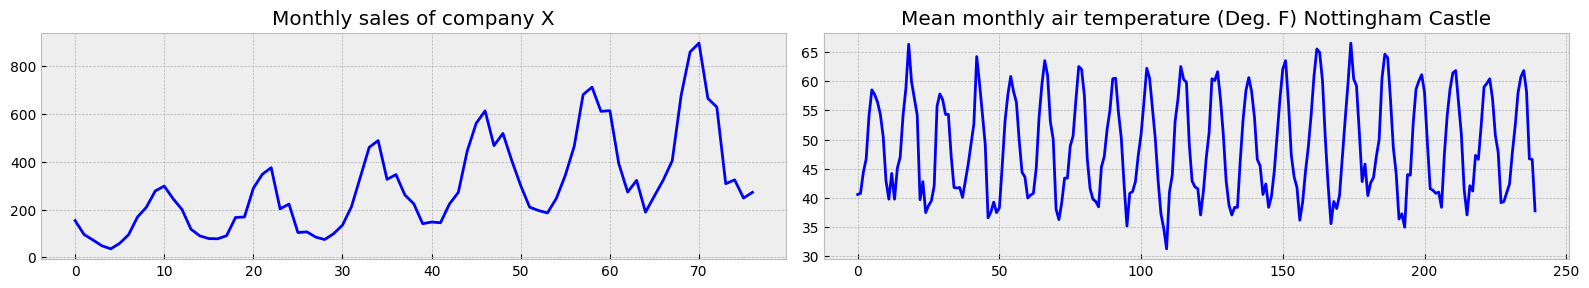

In [ ]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)

        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)

    plt.tight_layout()

##Monthly sales of company X

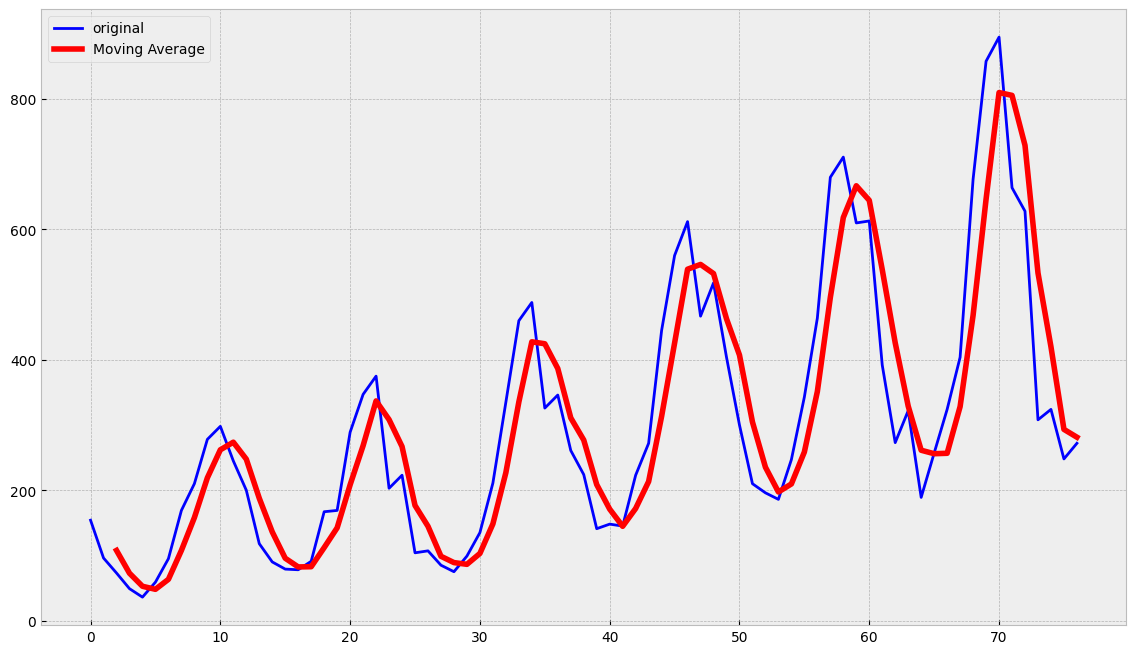

In [ ]:
ser_ma = moving_average(sales_of_company_x["Count"], 3) #Берем 3  т.к. у нас очень резкие подъемы и спады
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(sales_of_company_x["Count"], color='blue',label='original')
    plt.plot(ser_ma, color='red', linewidth='4', label='Moving Average')
    plt.legend()

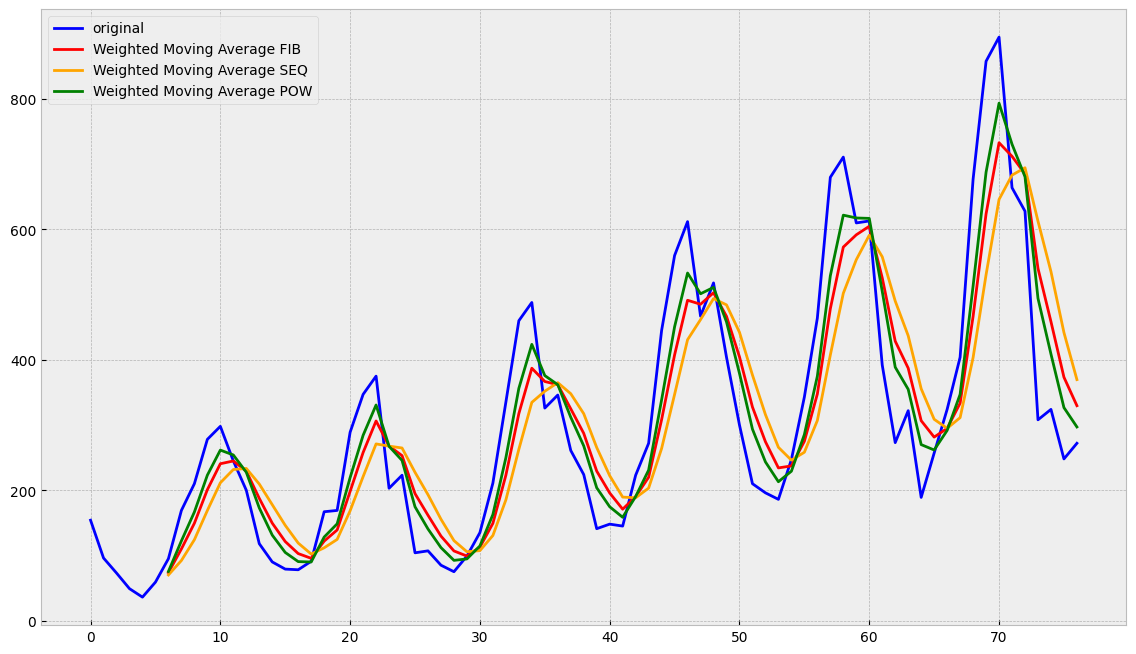

In [ ]:
#Попробуем wema
s=sales_of_company_x["Count"]
wma_fib = weighted_moving_average(s, 7, [1,1,2,3,5,8,13])
wma_seq = weighted_moving_average(s, 7, [1,2,3,4,5,6,7])
wma_pow = weighted_moving_average(s, 7, [1,2,4,8,16,32,64])


with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(sales_of_company_x["Count"], color='blue',label='original')
    plt.plot(wma_fib, color='red', linewidth='2', label='Weighted Moving Average FIB')
    plt.plot(wma_seq, color='orange', linewidth='2', label='Weighted Moving Average SEQ')
    plt.plot(wma_pow, color='green', linewidth='2', label='Weighted Moving Average POW')
    plt.legend()

In [ ]:
#WEMA сработало не очень точно

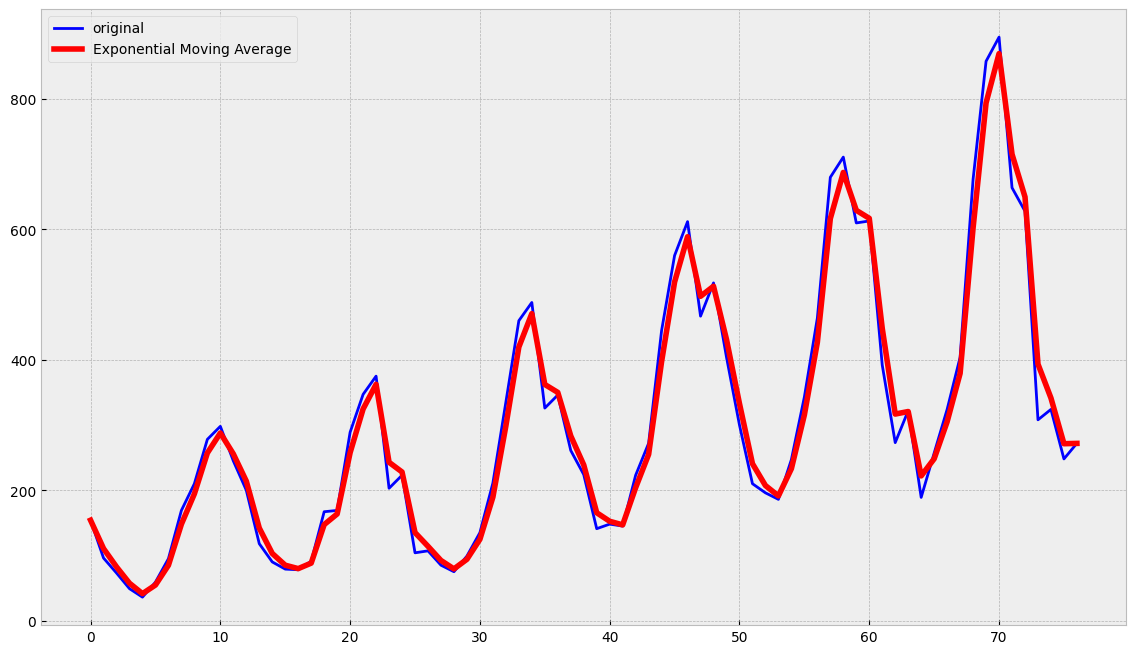

In [ ]:
#Попробуем ema
ser_ema = exponential_moving_average(sales_of_company_x["Count"], 0.75)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(sales_of_company_x["Count"], color='blue',label='original')
    plt.plot(ser_ema, color='red', linewidth='4', label='Exponential Moving Average')
    plt.legend()

EMA с alpha 0.75 почти идеально соответствует временному ряду

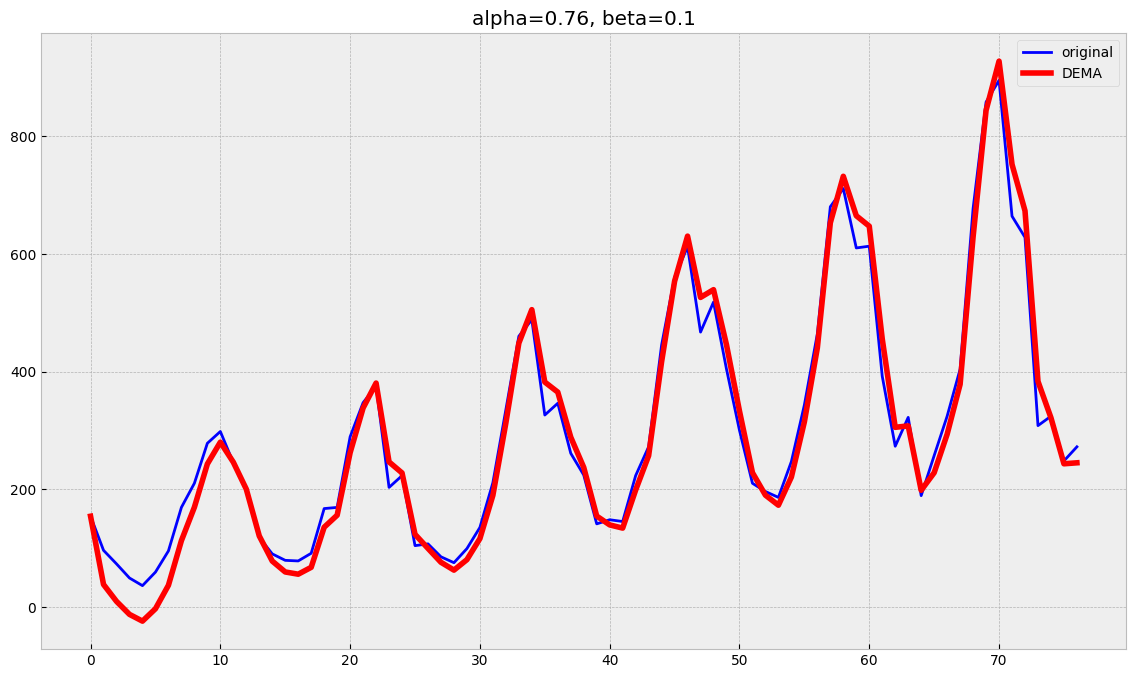

In [ ]:
#Попробуем двоеное сглаживание
plot_dema(sales_of_company_x["Count"],0.76, 0.1)

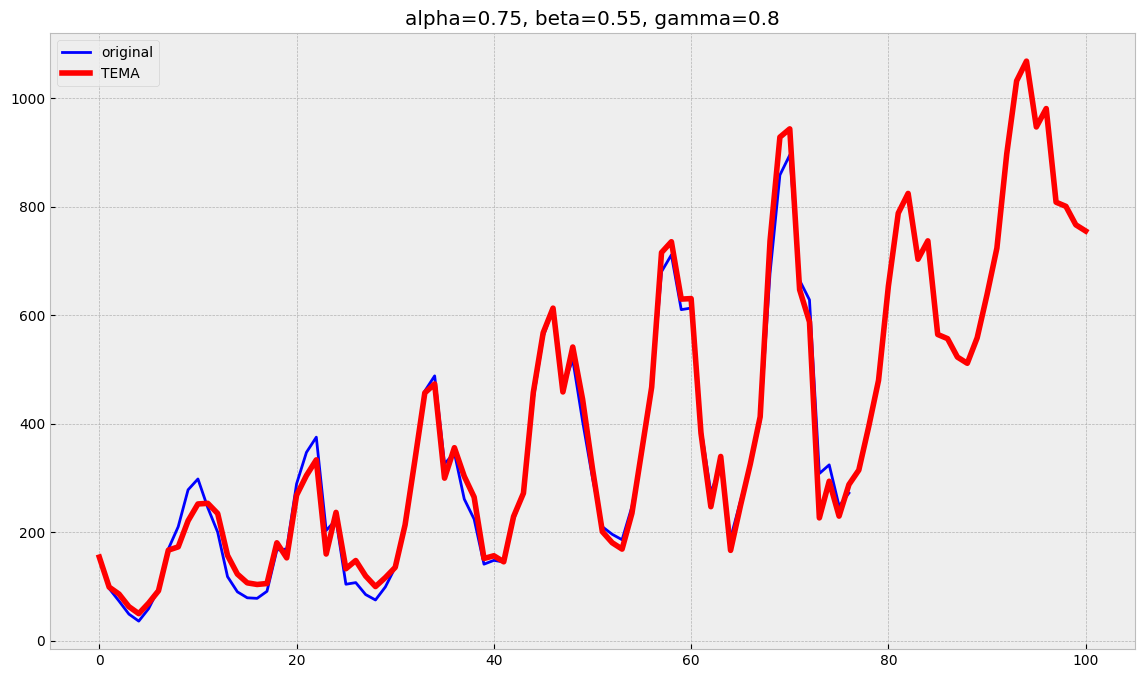

In [ ]:
#Попробуем TEMA
plot_tema(0.75, 0.55, 0.8)

In [ ]:
#Проверяем качество через RMSE и находим минимальную ошибку
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
def mse_tema(X,train,test):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error
def mse_ma(n,train,test):
    result = moving_average(train,n)
    predictions = result[-len(test):]
    error = mean_squared_error(predictions,test)
    return error
def mse_wema(weights,n,train,test):
    result = weighted_moving_average(train,n,weights)
    predictions = result[-len(test):]
    error = mean_squared_error(predictions,test)
    return error
def mse_ema(alpha,train,test):
    result = exponential_moving_average(train,alpha)
    predictions = result[-len(test):]
    error = mean_squared_error(predictions,test)
    return error
def mse_dema(X,train,test):
    alpha, beta = X
    result = double_ema(train, alpha, beta)
    predictions = result[-len(test):]
    error = mean_squared_error(predictions,test)
    return error

In [ ]:
orig_ser=sales_of_company_x["Count"]
train,test,val = orig_ser[:60], orig_ser[60:70], orig_ser[70:]
print("Moving average mse:",mse_ma(3,train,test))
print("weighted average mse (FIB): ",mse_wema([1,1,2,3,5,8,13],7,train,test))
print("weighted average mse (SEQ): ",mse_wema([1,2,3,4,5,6,7],7,train,test))
print("weighted average mse (POW): ",mse_wema([1,2,4,8,16,32,64],7,train,test))
print("Exponential Moving Average mse: ",mse_ema(0.75,train,test))
print("Double Moving Average mse: ",mse_dema((0.76, 0.1),train,test))


Moving average mse: 11638.9
weighted average mse (FIB):  14572.493388429753
weighted average mse (SEQ):  16121.731122448977
weighted average mse (POW):  15849.615927831857
Exponential Moving Average mse:  23640.515469012247
Double Moving Average mse:  25469.443004656634


In [ ]:
#Попробуем пооптимизировать, что можем
opt_tema = minimize(mse_tema, x0=[0,0,0],args=(train,test), method="L-BFGS-B", bounds = ((0, 3), (0, 3), (0, 3)))

opt_ema=minimize(mse_ema, x0=0,args=(train,test), method="L-BFGS-B", bounds=[(0,3)] )
opt_dema=minimize(mse_dema, x0=[0,0],args=(train,test), method="L-BFGS-B", bounds = ((0, 3),(0,3)))


In [ ]:
opt_ema

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 15227.16881320821
        x: [ 4.199e-01]
      nit: 7
      jac: [ 1.819e-03]
     nfev: 28
     njev: 14
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>

In [ ]:
opt_tema

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 2820.1364027478253
        x: [ 3.124e-01  6.792e-02  1.223e+00]
      nit: 23
      jac: [ 1.399e-01 -3.720e-02 -3.429e-02]
     nfev: 180
     njev: 45
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

In [ ]:
opt_dema

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 65.41499999999967
        x: [ 0.000e+00  0.000e+00]
      nit: 0
      jac: [ 1.093e+02  0.000e+00]
     nfev: 3
     njev: 1
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

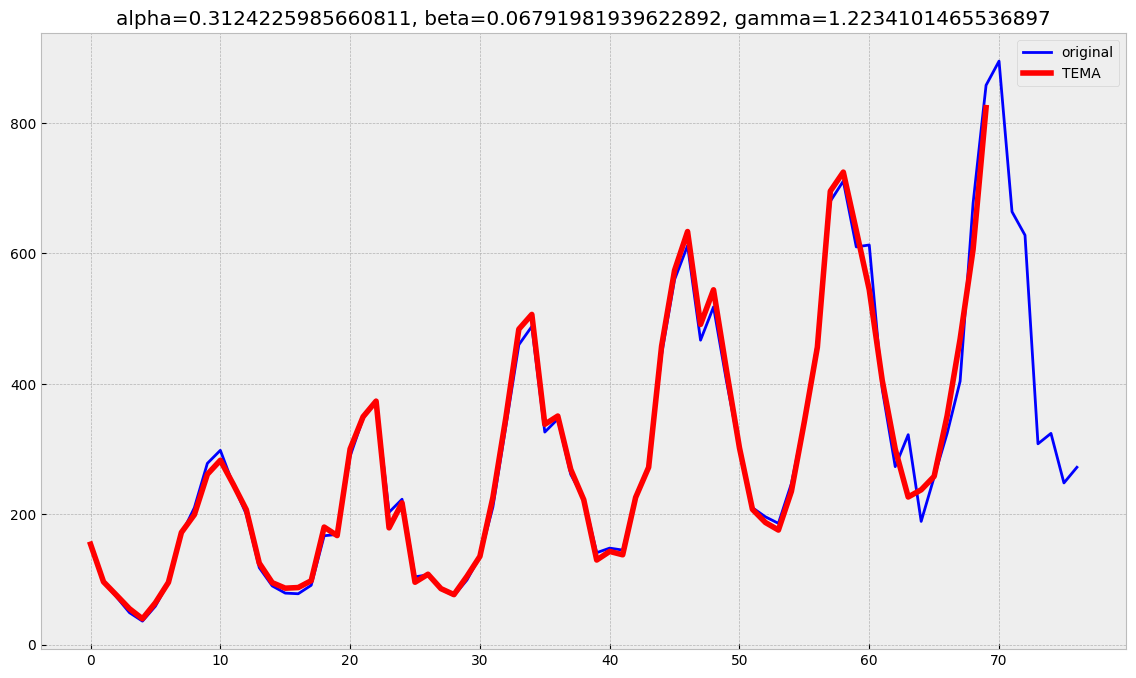

In [ ]:
#Наименьшая RMSE выходит на TEMA . Выбираем его и рисуем график по полученным параметрам
alpha_opt, beta_opt, gamma_opt = opt_tema.x
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train,  n_preds=len(test))


Мы смогли достаточно неплохо приблизить модель ( с ошибкой 2820.136)


##Mean monthly air temperature (Deg. F) Nottingham Castle

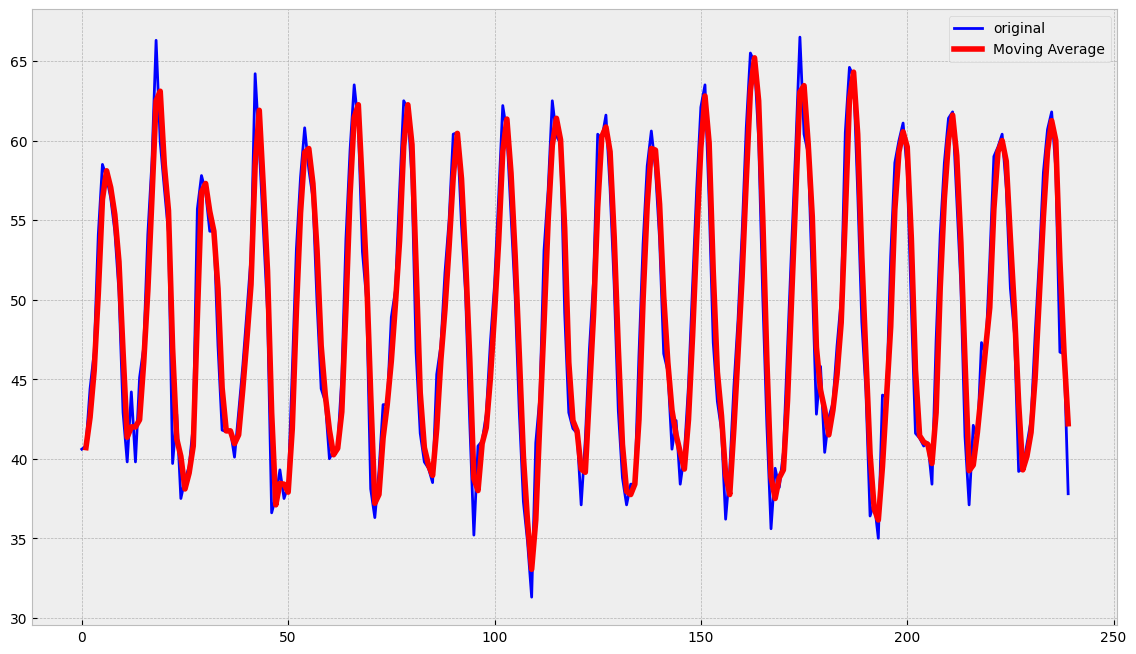

In [ ]:
ser_ma = moving_average(mean_monthly_temp["Deg"], 2)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(mean_monthly_temp["Deg"], color='blue',label='original')
    plt.plot(ser_ma, color='red', linewidth='4', label='Moving Average')
    plt.legend()

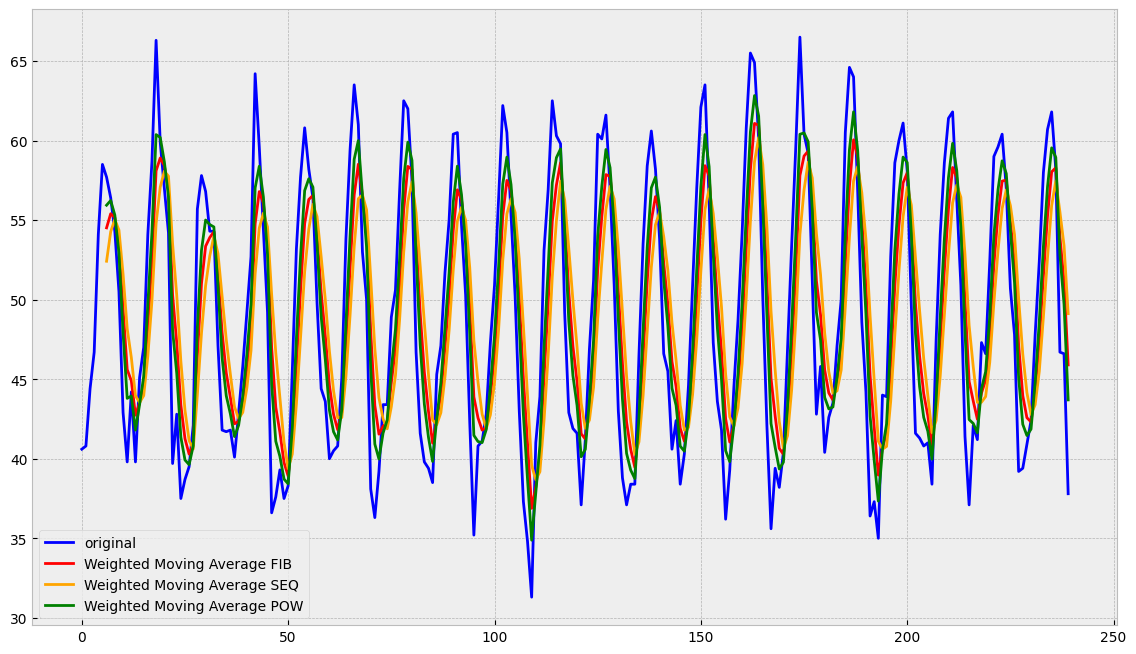

In [ ]:
s=mean_monthly_temp["Deg"]
wma_fib = weighted_moving_average(s, 7, [1,1,2,3,5,8,13])
wma_seq = weighted_moving_average(s, 7, [1,2,3,4,5,6,7])
wma_pow = weighted_moving_average(s, 7, [1,2,4,8,16,32,64])


with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(mean_monthly_temp["Deg"], color='blue',label='original')
    plt.plot(wma_fib, color='red', linewidth='2', label='Weighted Moving Average FIB')
    plt.plot(wma_seq, color='orange', linewidth='2', label='Weighted Moving Average SEQ')
    plt.plot(wma_pow, color='green', linewidth='2', label='Weighted Moving Average POW')
    plt.legend()

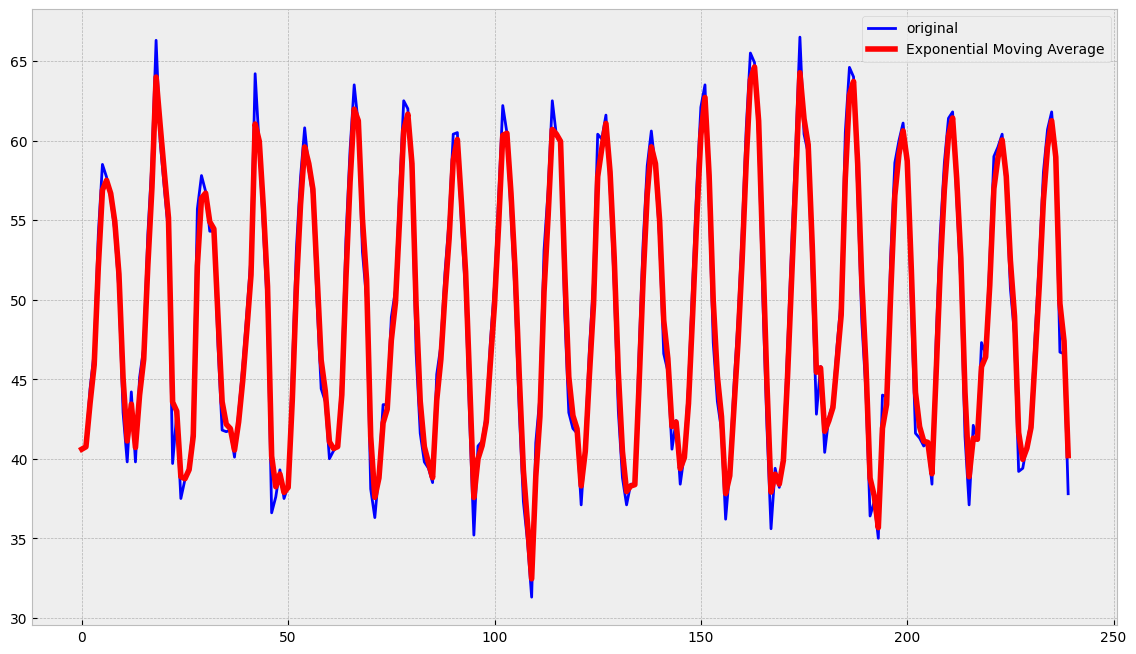

In [ ]:
#Попробуем ema
ser_ema = exponential_moving_average(mean_monthly_temp["Deg"], 0.75)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(mean_monthly_temp["Deg"], color='blue',label='original')
    plt.plot(ser_ema, color='red', linewidth='4', label='Exponential Moving Average')
    plt.legend()

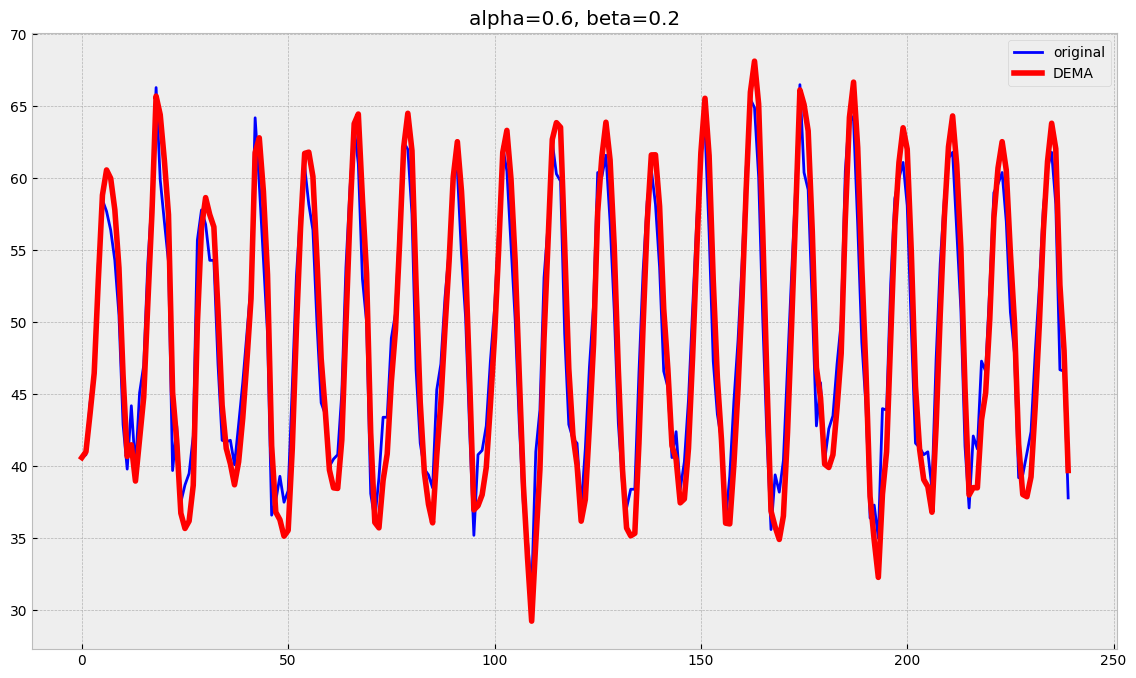

In [ ]:
plot_dema(mean_monthly_temp["Deg"],0.6,0.2)

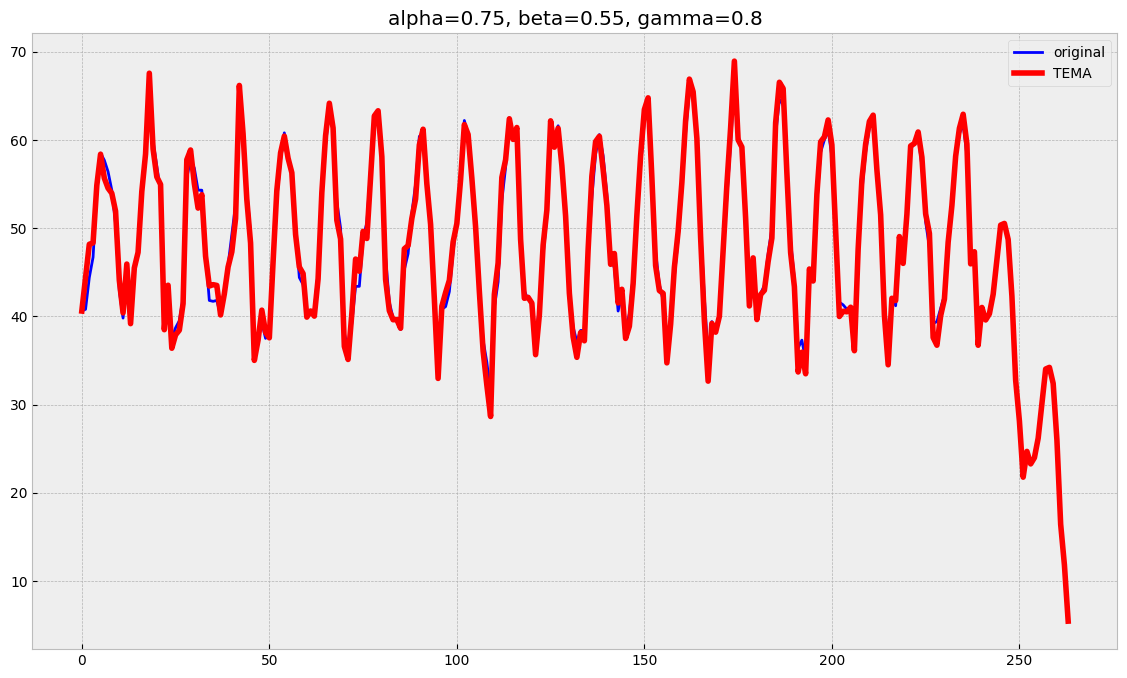

In [ ]:
plot_tema(0.75, 0.55, 0.8,ser=mean_monthly_temp["Deg"],ser_to_plot=mean_monthly_temp["Deg"])

In [ ]:
#Проверяем RMSE
orig_ser=mean_monthly_temp["Deg"]
train,test,val = orig_ser[:60], orig_ser[60:70], orig_ser[70:]
print("Moving average mse:",mse_ma(3,train,test))
print("weighted average mse (FIB): ",mse_wema([1,1,2,3,5,8,13],7,train,test))
print("weighted average mse (SEQ): ",mse_wema([1,2,3,4,5,6,7],7,train,test))
print("weighted average mse (POW): ",mse_wema([1,2,4,8,16,32,64],7,train,test))
print("Exponential Moving Average mse: ",mse_ema(0.75,train,test))
print("Double Moving Average mse: ",mse_dema((0.76, 0.1),train,test))

Moving average mse: 17.60144444444444
weighted average mse (FIB):  17.537717171717187
weighted average mse (SEQ):  13.242729591836738
weighted average mse (POW):  24.965277574555166
Exponential Moving Average mse:  47.746417820905094
Double Moving Average mse:  53.52425837240476


In [ ]:
#Попробуем пооптимизировать, что можем
opt_tema = minimize(mse_tema, x0=[0,0,0],args=(train,test), method="L-BFGS-B", bounds = ((0, 3), (0, 3), (0, 3)))

opt_ema=minimize(mse_ema, x0=0,args=(train,test), method="L-BFGS-B", bounds=[(0,3)] )
opt_dema=minimize(mse_dema, x0=[0,0],args=(train,test), method="L-BFGS-B", bounds = ((0, 3),(0,3)))

In [ ]:
opt_ema

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 19.279570990813877
        x: [ 3.576e-01]
      nit: 5
      jac: [ 1.066e-06]
     nfev: 22
     njev: 11
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>

In [ ]:
opt_tema

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 2.7807556841377656
        x: [ 1.634e+00  2.088e-02  0.000e+00]
      nit: 22
      jac: [ 4.174e-06  3.197e-06  1.928e+00]
     nfev: 140
     njev: 35
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

In [ ]:
opt_dema

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 65.41499999999967
        x: [ 0.000e+00  0.000e+00]
      nit: 0
      jac: [ 1.093e+02  0.000e+00]
     nfev: 3
     njev: 1
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

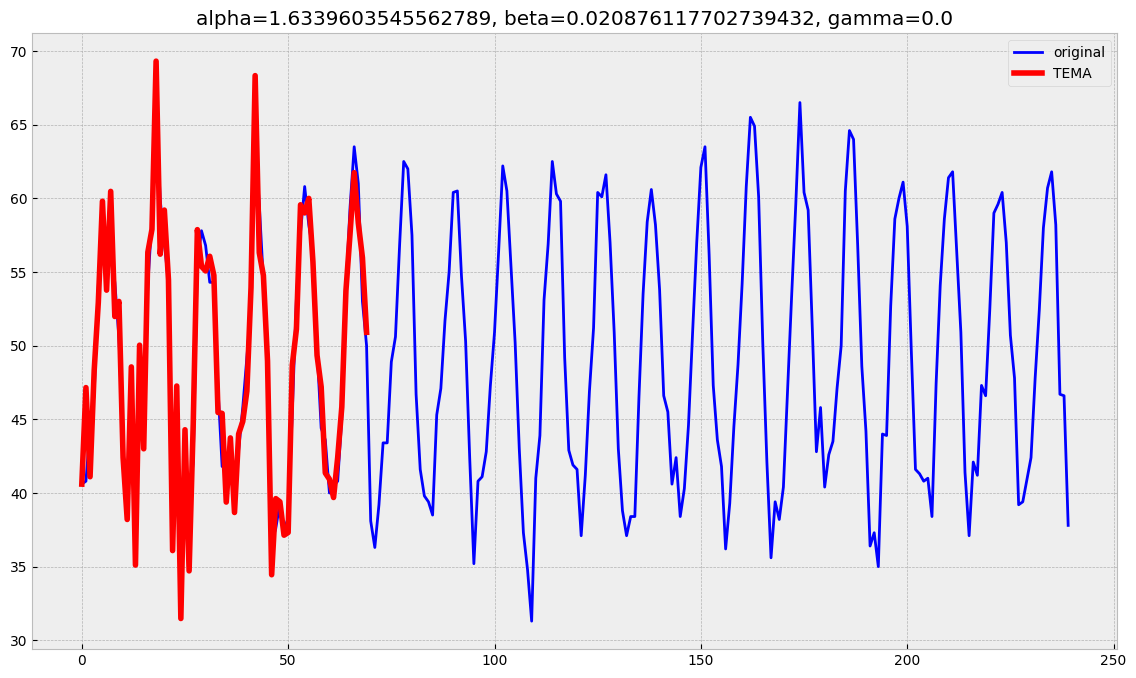

In [ ]:
#Наилучшая оптимизация вышла на TEMA.построим график
alpha_opt, beta_opt, gamma_opt = opt_tema.x
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train,ser_to_plot=mean_monthly_temp["Deg"],  n_preds=len(test))


Мы получили модель со среднеквадратичной ошибкой 2.7

Тройное экспоненциальное сглаживание оказалось потимальным в первом случае, т.к. хорошо может описать небольшие всплески временного ряда на падениях, а во втором случае - также хорошо смогло описать небольише всплески помимо основной сезонности.